Загрузка логов из: /mnt/d/Study/Code/ml/TradingAgentClassicRL/training_data/logs
  ✓ Загружен: exp_qlearning_v2 -> QLearning_v2 (Base) (4100 эпизодов)
  ✓ Загружен: exp_qlearning_v2_finetune -> QLearning_v2_finetune (FT) (2360 эпизодов)
  ✓ Загружен: exp_sarsa_v2 -> SARSA_v2 (Base) (5000 эпизодов)
  ✓ Загружен: exp_sarsa_v2_finetune -> SARSA_v2_finetune (FT) (4000 эпизодов)
  ✓ Загружен: exp_sarsa_lambda_v2 -> SARSA_Lambda_v2 (Base) (5000 эпизодов)
  ✓ Загружен: exp_sarsa_lambda_v2_finetune -> sarsa_lambda (FT) (10 эпизодов)
  ✓ Загружен: exp_monte_carlo_v2 -> Monte_Carlo_v2 (Base) (5000 эпизодов)
  Пропуск: exp_monte_carlo_v2_finetune (не найден)

Базовые агенты (Training):
  1. QLearning_v2 (Base) (эпизодов: 4100)
  2. SARSA_v2 (Base) (эпизодов: 5000)
  3. SARSA_Lambda_v2 (Base) (эпизодов: 5000)
  4. Monte_Carlo_v2 (Base) (эпизодов: 5000)

Агенты с дообучением (Finetuning):
  1. QLearning_v2_finetune (FT) (эпизодов: 2360)
  2. SARSA_v2_finetune (FT) (эпизодов: 4000)
  3. sarsa_lambda

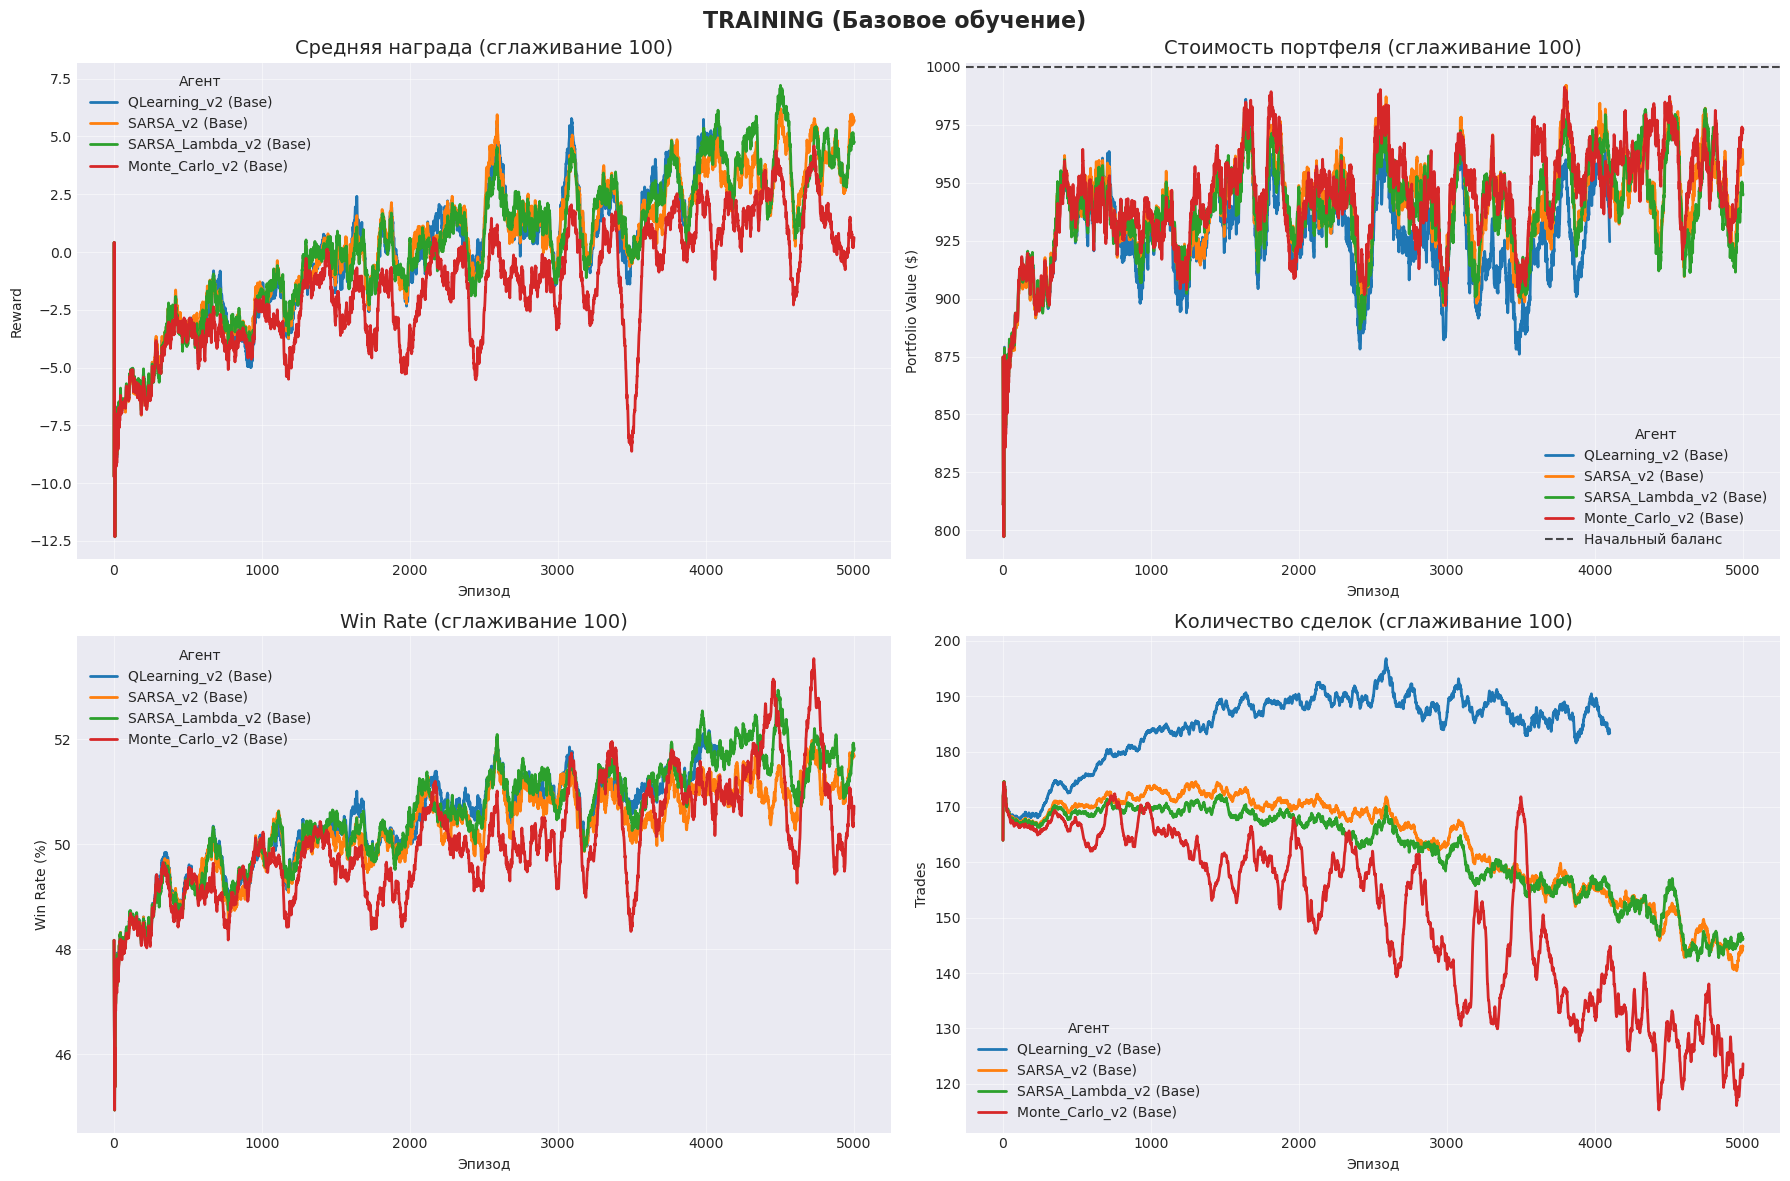

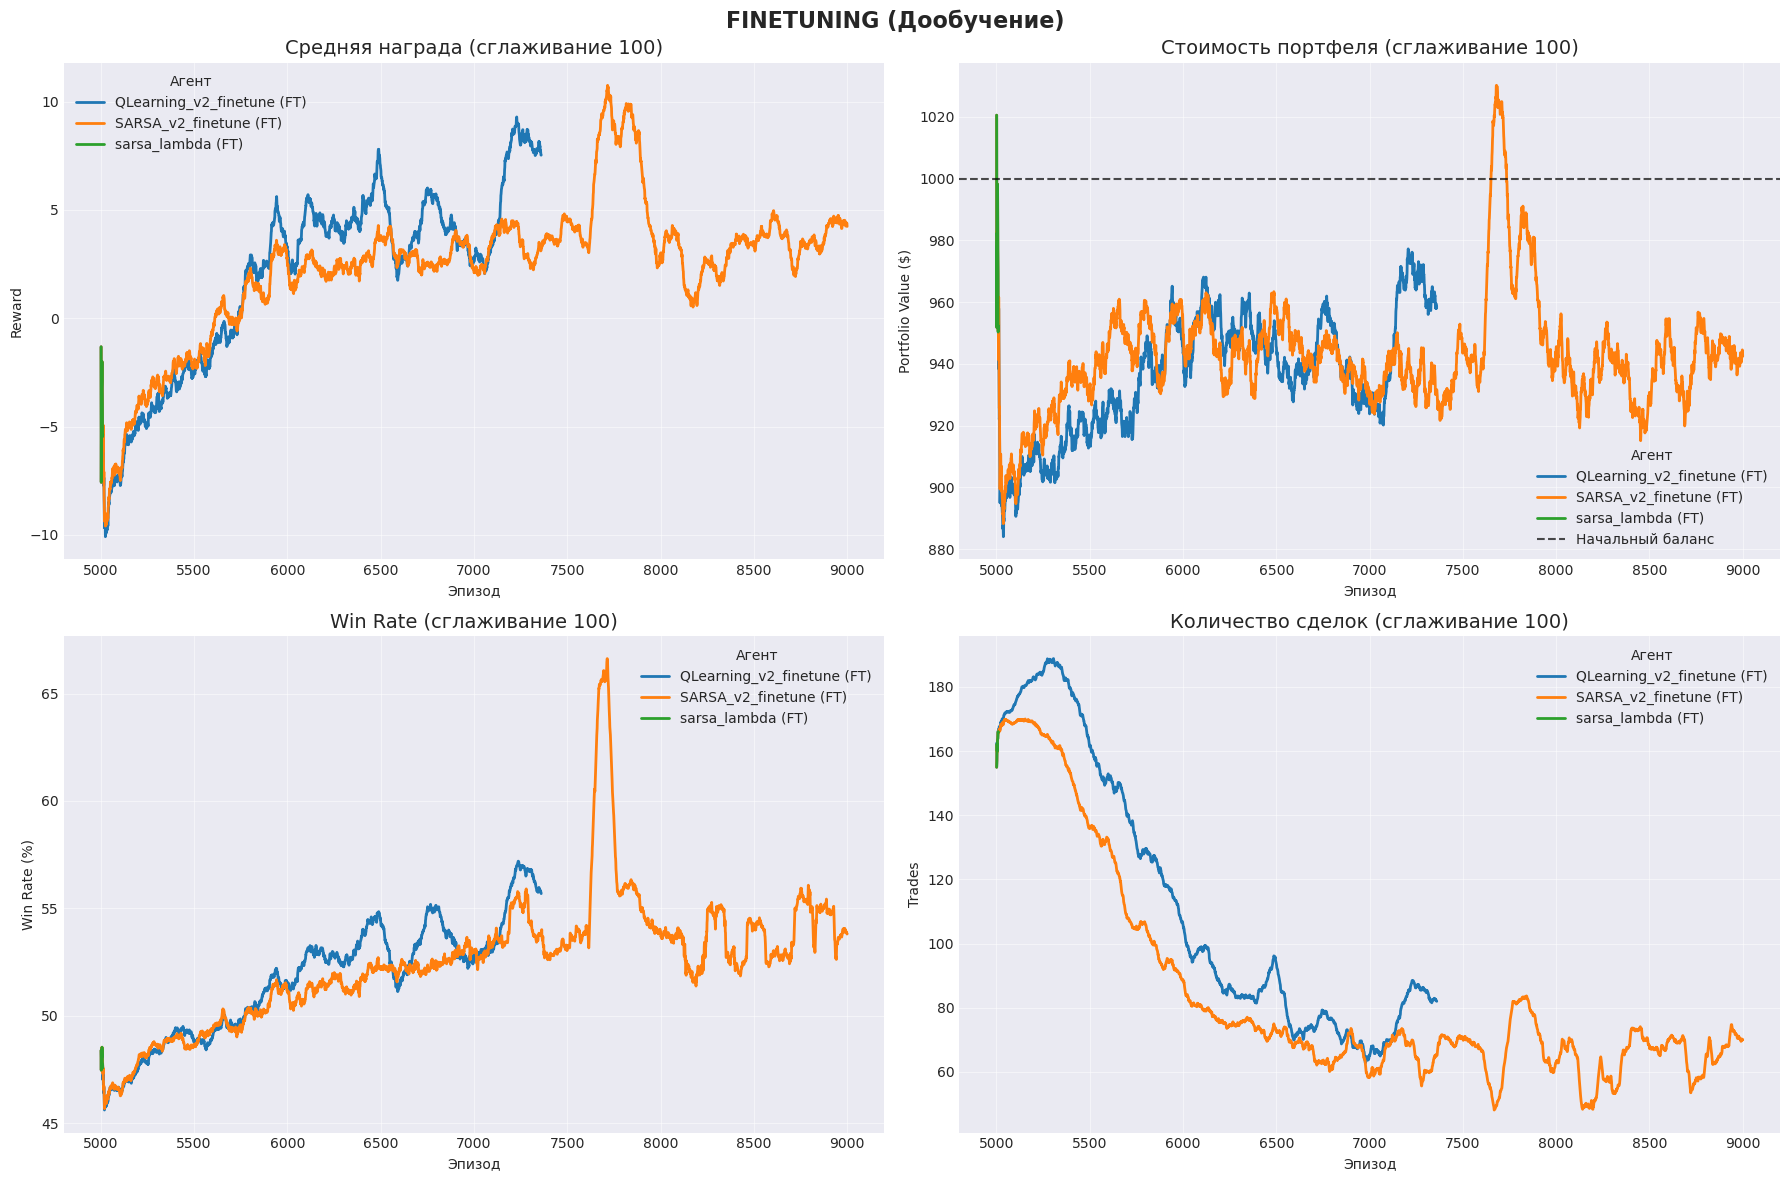

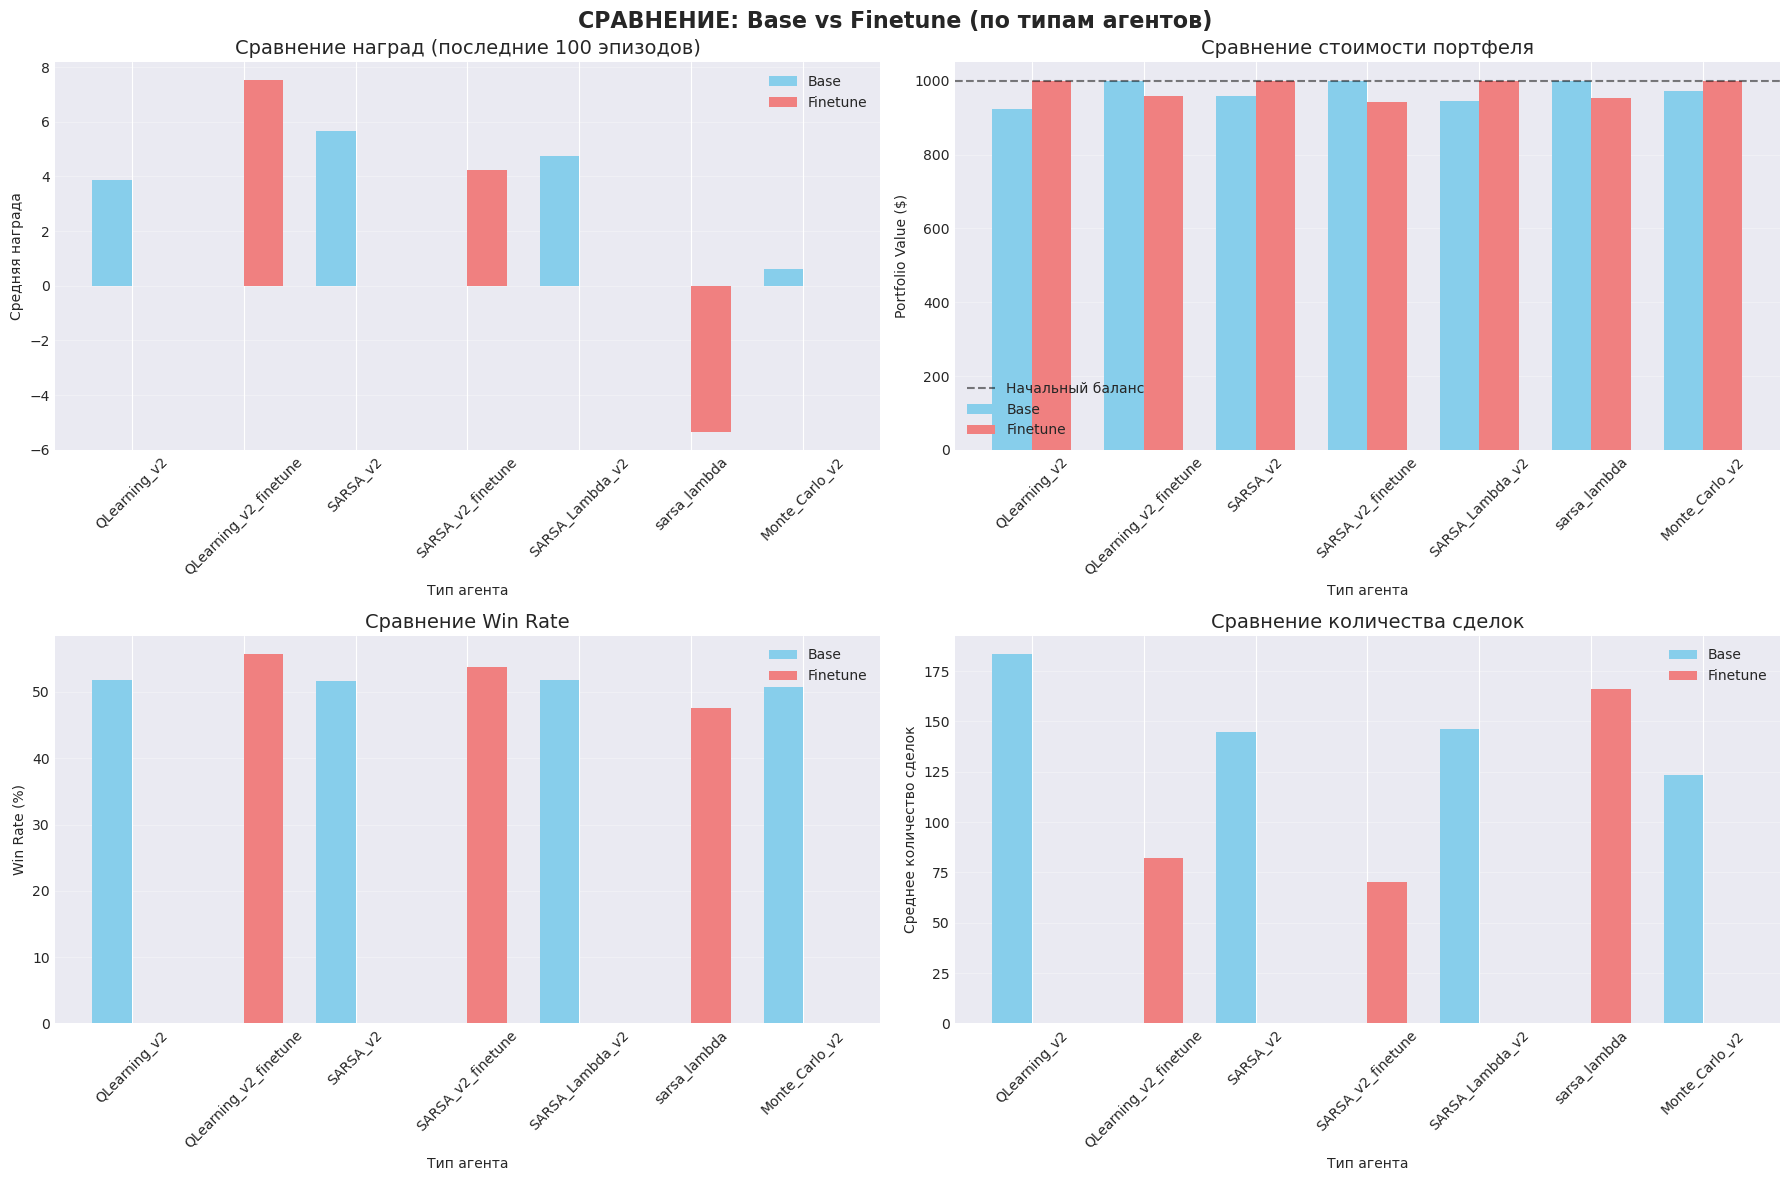

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from pathlib import Path
import os
import sys
import numpy as np

current_dir = Path.cwd()
if current_dir.name == "notebooks":
    project_root = current_dir.parent
    sys.path.insert(0, str(project_root))
else:
    project_root = Path(os.getcwd())
    sys.path.insert(0, str(project_root))

WINDOW_SIZE = 100 
TRAIN_VERSION = "v2"

agent_types = ["QLearning", "SARSA", "SARSA_Lambda", "Monte_Carlo"]
experiment_names = []

for agent in agent_types:
    experiment_names.append(f"exp_{agent.lower()}_{TRAIN_VERSION}")
    experiment_names.append(f"exp_{agent.lower()}_{TRAIN_VERSION}_finetune")

all_data = []
base_log_dir = Path(project_root) / "training_data" / "logs"

if not base_log_dir.exists():
    print(f"Директория логов не найдена: {base_log_dir}")
    print("Убедитесь, что обучение было запущено.")
else:
    print(f"Загрузка логов из: {base_log_dir}")

for exp_name in experiment_names:
    exp_dir = base_log_dir / exp_name
    
    if not exp_dir.exists():
        print(f"  Пропуск: {exp_name} (не найден)")
        continue
    
    try:
        episodes_csv = exp_dir / "episodes.csv"
        summary_json = exp_dir / "training_summary.json"
        
        if not episodes_csv.exists():
            print(f"  Пропуск: {exp_name} (нет episodes.csv)")
            continue
            
        episodes_df = pd.read_csv(episodes_csv)
        
        agent_label = None
        if summary_json.exists():
            with open(summary_json) as f:
                summary = json.load(f)
            agent_raw_name = summary["config"]["agent_name"]
            if "finetune" in exp_name:
                agent_label = f"{agent_raw_name} (FT)"
            else:
                agent_label = f"{agent_raw_name} (Base)"
        else:
            agent_name = exp_name.replace("exp_", "").replace(f"_{TRAIN_VERSION}", "")
            if "_finetune" in agent_name:
                agent_name = agent_name.replace("_finetune", "")
                agent_label = f"{agent_name} (FT)"
            else:
                agent_label = f"{agent_name} (Base)"
            
        episodes_df["agent"] = agent_label
        episodes_df["experiment"] = exp_name
        episodes_df["is_finetune"] = "finetune" in exp_name
        all_data.append(episodes_df)
        print(f"  ✓ Загружен: {exp_name} -> {agent_label} ({len(episodes_df)} эпизодов)")
        
    except Exception as e:
        print(f"  ✗ Ошибка при загрузке {exp_name}: {e}")

if not all_data:
    print(f"\nНе удалось загрузить данные ни одного эксперимента.")
    print(f"Проверьте:")
    print(f"  1. Путь к логам: {base_log_dir}")
    print(f"  2. TRAIN_VERSION: {TRAIN_VERSION}")
    print("Нет данных для анализа.")
else:
    df = pd.concat(all_data, ignore_index=True)
    
    base_agents = df[~df["is_finetune"]]["agent"].unique()
    ft_agents = df[df["is_finetune"]]["agent"].unique()
    
    print(f"\nБазовые агенты (Training):")
    for i, agent in enumerate(base_agents):
        agent_data = df[df["agent"] == agent]
        print(f"  {i+1}. {agent} (эпизодов: {len(agent_data)})")
    
    print(f"\nАгенты с дообучением (Finetuning):")
    for i, agent in enumerate(ft_agents):
        agent_data = df[df["agent"] == agent]
        print(f"  {i+1}. {agent} (эпизодов: {len(agent_data)})")
    
    print(f"\n✓ Всего загружено {len(df['agent'].unique())} уникальных агентов из {len(all_data)} экспериментов.")

    final_metrics = (
        df.groupby("agent")
        .tail(WINDOW_SIZE)
        .groupby("agent")
        [["reward", "portfolio_value", "win_rate", "n_trades", "max_drawdown", "avg_pnl"]]
        .agg({
            "reward": "mean",
            "portfolio_value": "mean",
            "win_rate": "mean",
            "n_trades": "mean",
            "max_drawdown": "mean",
            "avg_pnl": "mean",
        })
    )

    final_metrics.columns = [
        "Reward (Avg)", 
        "Balance $ (Avg)", 
        "Win Rate % (Avg)", 
        "Trades (Avg)", 
        "Max DD (Avg)",
        "Avg PnL (Avg)"
    ]

    final_metrics = final_metrics.sort_values("Reward (Avg)", ascending=False)

    print(f"\n{'='*80}")
    print(f"Финальные результаты (среднее за последние {WINDOW_SIZE} эпизодов)")
    print(f"{'='*80}")
    print(final_metrics.round(2))
    print(f"{'='*80}\n")

    plt.style.use('seaborn-v0_8-darkgrid')

    if len(base_agents) > 0:
        fig1, axes1 = plt.subplots(2, 2, figsize=(18, 12))
        fig1.suptitle('TRAINING (Базовое обучение)', fontsize=16, fontweight='bold')
        
        ax1 = axes1[0, 0]
        for agent in base_agents:
            agent_data = df[df["agent"] == agent].sort_values("episode")
            if len(agent_data) > 0:
                smoothed = agent_data["reward"].rolling(window=WINDOW_SIZE, min_periods=1).mean()
                ax1.plot(agent_data["episode"], smoothed, label=agent, linewidth=2)
        
        ax1.set_title(f"Средняя награда (сглаживание {WINDOW_SIZE})", fontsize=14)
        ax1.set_xlabel("Эпизод")
        ax1.set_ylabel("Reward")
        ax1.legend(title="Агент", loc='best')
        ax1.grid(True, alpha=0.5)

        ax2 = axes1[0, 1]
        for agent in base_agents:
            agent_data = df[df["agent"] == agent].sort_values("episode")
            if len(agent_data) > 0:
                smoothed_balance = agent_data["portfolio_value"].rolling(window=WINDOW_SIZE, min_periods=1).mean()
                ax2.plot(agent_data["episode"], smoothed_balance, label=agent, linewidth=2)
        
        INITIAL_BALANCE = 1000.0
        ax2.axhline(y=INITIAL_BALANCE, color='black', linestyle='--', alpha=0.7, label='Начальный баланс')
        
        ax2.set_title(f"Стоимость портфеля (сглаживание {WINDOW_SIZE})", fontsize=14)
        ax2.set_xlabel("Эпизод")
        ax2.set_ylabel("Portfolio Value ($)")
        ax2.legend(title="Агент", loc='best')
        ax2.grid(True, alpha=0.5)

        ax3 = axes1[1, 0]
        for agent in base_agents:
            agent_data = df[df["agent"] == agent].sort_values("episode")
            if len(agent_data) > 0:
                smoothed_wr = agent_data["win_rate"].rolling(window=WINDOW_SIZE, min_periods=1).mean()
                ax3.plot(agent_data["episode"], smoothed_wr, label=agent, linewidth=2)
        
        ax3.set_title(f"Win Rate (сглаживание {WINDOW_SIZE})", fontsize=14)
        ax3.set_xlabel("Эпизод")
        ax3.set_ylabel("Win Rate (%)")
        ax3.legend(title="Агент", loc='best')
        ax3.grid(True, alpha=0.5)

        ax4 = axes1[1, 1]
        for agent in base_agents:
            agent_data = df[df["agent"] == agent].sort_values("episode")
            if len(agent_data) > 0:
                smoothed_trades = agent_data["n_trades"].rolling(window=WINDOW_SIZE, min_periods=1).mean()
                ax4.plot(agent_data["episode"], smoothed_trades, label=agent, linewidth=2)
        
        ax4.set_title(f"Количество сделок (сглаживание {WINDOW_SIZE})", fontsize=14)
        ax4.set_xlabel("Эпизод")
        ax4.set_ylabel("Trades")
        ax4.legend(title="Агент", loc='best')
        ax4.grid(True, alpha=0.5)

        plt.tight_layout()
        plt.show()

    if len(ft_agents) > 0:
        fig2, axes2 = plt.subplots(2, 2, figsize=(18, 12))
        fig2.suptitle('FINETUNING (Дообучение)', fontsize=16, fontweight='bold')
        
        ax1 = axes2[0, 0]
        for agent in ft_agents:
            agent_data = df[df["agent"] == agent].sort_values("episode")
            if len(agent_data) > 0:
                smoothed = agent_data["reward"].rolling(window=WINDOW_SIZE, min_periods=1).mean()
                ax1.plot(agent_data["episode"], smoothed, label=agent, linewidth=2)
        
        ax1.set_title(f"Средняя награда (сглаживание {WINDOW_SIZE})", fontsize=14)
        ax1.set_xlabel("Эпизод")
        ax1.set_ylabel("Reward")
        ax1.legend(title="Агент", loc='best')
        ax1.grid(True, alpha=0.5)

        ax2 = axes2[0, 1]
        for agent in ft_agents:
            agent_data = df[df["agent"] == agent].sort_values("episode")
            if len(agent_data) > 0:
                smoothed_balance = agent_data["portfolio_value"].rolling(window=WINDOW_SIZE, min_periods=1).mean()
                ax2.plot(agent_data["episode"], smoothed_balance, label=agent, linewidth=2)
        
        INITIAL_BALANCE = 1000.0
        ax2.axhline(y=INITIAL_BALANCE, color='black', linestyle='--', alpha=0.7, label='Начальный баланс')
        
        ax2.set_title(f"Стоимость портфеля (сглаживание {WINDOW_SIZE})", fontsize=14)
        ax2.set_xlabel("Эпизод")
        ax2.set_ylabel("Portfolio Value ($)")
        ax2.legend(title="Агент", loc='best')
        ax2.grid(True, alpha=0.5)

        ax3 = axes2[1, 0]
        for agent in ft_agents:
            agent_data = df[df["agent"] == agent].sort_values("episode")
            if len(agent_data) > 0:
                smoothed_wr = agent_data["win_rate"].rolling(window=WINDOW_SIZE, min_periods=1).mean()
                ax3.plot(agent_data["episode"], smoothed_wr, label=agent, linewidth=2)
        
        ax3.set_title(f"Win Rate (сглаживание {WINDOW_SIZE})", fontsize=14)
        ax3.set_xlabel("Эпизод")
        ax3.set_ylabel("Win Rate (%)")
        ax3.legend(title="Агент", loc='best')
        ax3.grid(True, alpha=0.5)

        ax4 = axes2[1, 1]
        for agent in ft_agents:
            agent_data = df[df["agent"] == agent].sort_values("episode")
            if len(agent_data) > 0:
                smoothed_trades = agent_data["n_trades"].rolling(window=WINDOW_SIZE, min_periods=1).mean()
                ax4.plot(agent_data["episode"], smoothed_trades, label=agent, linewidth=2)
        
        ax4.set_title(f"Количество сделок (сглаживание {WINDOW_SIZE})", fontsize=14)
        ax4.set_xlabel("Эпизод")
        ax4.set_ylabel("Trades")
        ax4.legend(title="Агент", loc='best')
        ax4.grid(True, alpha=0.5)

        plt.tight_layout()
        plt.show()

    if len(base_agents) > 0 and len(ft_agents) > 0:
        fig3, axes3 = plt.subplots(2, 2, figsize=(18, 12))
        fig3.suptitle('СРАВНЕНИЕ: Base vs Finetune (по типам агентов)', fontsize=16, fontweight='bold')
        
        agent_pairs = {}
        for agent in df["agent"].unique():
            base_name = agent.replace(" (Base)", "").replace(" (FT)", "")
            if base_name not in agent_pairs:
                agent_pairs[base_name] = {"base": None, "ft": None}
            
            if "(Base)" in agent:
                agent_pairs[base_name]["base"] = agent
            elif "(FT)" in agent:
                agent_pairs[base_name]["ft"] = agent
        
        colors = plt.cm.Set3(np.linspace(0, 1, len(agent_pairs)))
        
        ax1 = axes3[0, 0]
        bar_width = 0.35
        indices = np.arange(len(agent_pairs))
        
        base_rewards = []
        ft_rewards = []
        labels = []
        
        for idx, (agent_name, versions) in enumerate(agent_pairs.items()):
            labels.append(agent_name)
            
            if versions["base"]:
                base_data = df[df["agent"] == versions["base"]]
                if len(base_data) >= WINDOW_SIZE:
                    base_reward = base_data["reward"].tail(WINDOW_SIZE).mean()
                else:
                    base_reward = base_data["reward"].mean()
                base_rewards.append(base_reward)
            else:
                base_rewards.append(0)
            
            if versions["ft"]:
                ft_data = df[df["agent"] == versions["ft"]]
                if len(ft_data) >= WINDOW_SIZE:
                    ft_reward = ft_data["reward"].tail(WINDOW_SIZE).mean()
                else:
                    ft_reward = ft_data["reward"].mean()
                ft_rewards.append(ft_reward)
            else:
                ft_rewards.append(0)
        
        ax1.bar(indices - bar_width/2, base_rewards, bar_width, label='Base', color='skyblue')
        ax1.bar(indices + bar_width/2, ft_rewards, bar_width, label='Finetune', color='lightcoral')
        
        ax1.set_title("Сравнение наград (последние 100 эпизодов)", fontsize=14)
        ax1.set_xlabel("Тип агента")
        ax1.set_ylabel("Средняя награда")
        ax1.set_xticks(indices)
        ax1.set_xticklabels(labels, rotation=45)
        ax1.legend()
        ax1.grid(True, alpha=0.3, axis='y')

        ax2 = axes3[0, 1]
        base_values = []
        ft_values = []
        
        for idx, (agent_name, versions) in enumerate(agent_pairs.items()):
            if versions["base"]:
                base_data = df[df["agent"] == versions["base"]]
                if len(base_data) >= WINDOW_SIZE:
                    base_value = base_data["portfolio_value"].tail(WINDOW_SIZE).mean()
                else:
                    base_value = base_data["portfolio_value"].mean()
                base_values.append(base_value)
            else:
                base_values.append(INITIAL_BALANCE)
            
            if versions["ft"]:
                ft_data = df[df["agent"] == versions["ft"]]
                if len(ft_data) >= WINDOW_SIZE:
                    ft_value = ft_data["portfolio_value"].tail(WINDOW_SIZE).mean()
                else:
                    ft_value = ft_data["portfolio_value"].mean()
                ft_values.append(ft_value)
            else:
                ft_values.append(INITIAL_BALANCE)
        
        ax2.bar(indices - bar_width/2, base_values, bar_width, label='Base', color='skyblue')
        ax2.bar(indices + bar_width/2, ft_values, bar_width, label='Finetune', color='lightcoral')
        ax2.axhline(y=INITIAL_BALANCE, color='black', linestyle='--', alpha=0.5, label='Начальный баланс')
        
        ax2.set_title("Сравнение стоимости портфеля", fontsize=14)
        ax2.set_xlabel("Тип агента")
        ax2.set_ylabel("Portfolio Value ($)")
        ax2.set_xticks(indices)
        ax2.set_xticklabels(labels, rotation=45)
        ax2.legend()
        ax2.grid(True, alpha=0.3, axis='y')

        ax3 = axes3[1, 0]
        base_winrates = []
        ft_winrates = []
        
        for idx, (agent_name, versions) in enumerate(agent_pairs.items()):
            if versions["base"]:
                base_data = df[df["agent"] == versions["base"]]
                if len(base_data) >= WINDOW_SIZE:
                    base_winrate = base_data["win_rate"].tail(WINDOW_SIZE).mean()
                else:
                    base_winrate = base_data["win_rate"].mean()
                base_winrates.append(base_winrate)
            else:
                base_winrates.append(0)
            
            if versions["ft"]:
                ft_data = df[df["agent"] == versions["ft"]]
                if len(ft_data) >= WINDOW_SIZE:
                    ft_winrate = ft_data["win_rate"].tail(WINDOW_SIZE).mean()
                else:
                    ft_winrate = ft_data["win_rate"].mean()
                ft_winrates.append(ft_winrate)
            else:
                ft_winrates.append(0)
        
        ax3.bar(indices - bar_width/2, base_winrates, bar_width, label='Base', color='skyblue')
        ax3.bar(indices + bar_width/2, ft_winrates, bar_width, label='Finetune', color='lightcoral')
        
        ax3.set_title("Сравнение Win Rate", fontsize=14)
        ax3.set_xlabel("Тип агента")
        ax3.set_ylabel("Win Rate (%)")
        ax3.set_xticks(indices)
        ax3.set_xticklabels(labels, rotation=45)
        ax3.legend()
        ax3.grid(True, alpha=0.3, axis='y')

        ax4 = axes3[1, 1]
        base_trades = []
        ft_trades = []
        
        for idx, (agent_name, versions) in enumerate(agent_pairs.items()):
            if versions["base"]:
                base_data = df[df["agent"] == versions["base"]]
                if len(base_data) >= WINDOW_SIZE:
                    base_trade = base_data["n_trades"].tail(WINDOW_SIZE).mean()
                else:
                    base_trade = base_data["n_trades"].mean()
                base_trades.append(base_trade)
            else:
                base_trades.append(0)
            
            if versions["ft"]:
                ft_data = df[df["agent"] == versions["ft"]]
                if len(ft_data) >= WINDOW_SIZE:
                    ft_trade = ft_data["n_trades"].tail(WINDOW_SIZE).mean()
                else:
                    ft_trade = ft_data["n_trades"].mean()
                ft_trades.append(ft_trade)
            else:
                ft_trades.append(0)
        
        ax4.bar(indices - bar_width/2, base_trades, bar_width, label='Base', color='skyblue')
        ax4.bar(indices + bar_width/2, ft_trades, bar_width, label='Finetune', color='lightcoral')
        
        ax4.set_title("Сравнение количества сделок", fontsize=14)
        ax4.set_xlabel("Тип агента")
        ax4.set_ylabel("Среднее количество сделок")
        ax4.set_xticks(indices)
        ax4.set_xticklabels(labels, rotation=45)
        ax4.legend()
        ax4.grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plt.show()